In [1]:

import time
import random
import numpy as np
import math as m
from scipy import ndimage
import cv2
import itertools
import torch

import torch.multiprocessing as mp
import kogers_colors 


from individual import Individual
from rotate import rotate

from __future__ import division


kc = kogers_colors.Colors()

def close_cv2():
    for ind in range(10):
        cv2.destroyAllWindows()
        cv2.waitKey(1)
        
def normalize(vec):
    vec_mag = np.linalg.norm(vec)
    vec_mag = np.maximum(vec_mag, EPSILON)
    vec_norm = vec / vec_mag
    return vec_norm

# differentiable equivalent of np.where
# cond could be a FloatTensor with zeros and ones

def where(cond, x_1, x_2):
    ones = cond.clone().zero_() + 1
    return (cond * x_1) + ((ones-cond) * x_2)
 
EPSILON = .0000001
    
class Simulation():
    
    def __init__(self, num_agents=400, number_of_states=2, arena_size=1000,
                 max_turning_rate=114.5, body_size=4.0, zoa=12.0,
                 zor=2.0, zoo=12.0, speed=10, angular_error_sd=0.0, 
                 ko=0.25, ka=0.25, timestep=0.2, periodic_boundary=True,
                 draw_sim=True, state_threshold=0.5, num_active=.5,
                 omega=.5, video=False, video_file='testvid.avi',
                 social_weight=0.85, number_of_cells=2):
        
        
        self.FloatTensor = torch.FloatTensor
        self.IntTensor = torch.IntTensor
        
        cuda = True
        if cuda:
            self.FloatTensor = torch.cuda.FloatTensor 
            self.IntTensor = torch.cuda.IntTensor 
        
        self.num_agents = num_agents
        self.number_of_states = number_of_states
        self.arena_size = arena_size
        self.max_turning_rate = max_turning_rate
        self.body_size = body_size
        self.zoa = zoa * body_size
        self.zor = zor * body_size
        self.zoo = zoo * body_size
        self.speed = speed
        self.angular_error_sd = angular_error_sd
        self.ko = ko
        self.ka = ka
        self.timestep = timestep
        
        self.top_left = np.zeros(2)
        self.bottom_right = np.ones(2) * arena_size
        self.number_of_cells = number_of_cells
        self.next_number_of_cells = number_of_cells
        self.cell_size = arena_size / self.number_of_cells
        self.total_cells = self.number_of_cells ** 2
        
        self.agents = self.generate_agents()
        
        self.periodic_boundary = periodic_boundary
        
        self.draw_sim = draw_sim
        self.state_threshold = state_threshold
        self.num_active = int(num_agents * num_active)
        self.video = video
        self.video_file = video_file
        if self.video:
            print('Video initialized...')
            self.out = self.initialize_video()
        else:
            self.out = None 
        
        self.social_weight = self.FloatTensor([social_weight])
        self.omega = self.FloatTensor([omega])
            
        
        #output of the video recorder, if enabled
        
    def initialize_video(self):
        fourcc = cv2.VideoWriter_fourcc(*'ffv1')
        out = cv2.VideoWriter(filename=self.video_file, fourcc=fourcc, fps=30, 
                              frameSize=(int(self.arena_size), int(self.arena_size)), isColor=True)
        return out

    def create_mask(self, r, inner_r, outer_r):
        """Return a mask that is False if distance is within the specified range

        arguments:
        r -- matrix containg distances between all individuals: shape() = (n,m)
        inner_r -- minimum distance (exclusive)
        outer_r -- maximum distance (exclusive)

        return matrix shape = (n,m,2)
        """
        mask = (r > inner_r) * (r < outer_r) * -1 + 1
        mask = torch.unsqueeze(mask, 2)
        mask = mask.repeat(1,1,2)
        return(mask)
    
    def create_mask_1d(self, r, inner_r, outer_r):
        """Return a mask that is False is distance is within the specified range

        arguments:
        r -- matrix containg distances between all individuals: shape() = (n,m)
        inner_r -- minimum distance (exclusive)
        outer_r -- maximum distance (exclusive)

        return matrix shape = (n,m)
        """
        mask = (r > inner_r) * (r < outer_r) * -1 + 1
        return(mask)

    def zone_vec_v(self, expanded_val, mask):
        """Apply mask to velocities calculate social alignment
        """
        vals = expanded_val.repeat(1, mask.size()[1], 1)
        #take term from vals where mask is true and from zeros when false
        
        vals = vals.masked_fill_(mask, 0.0)
        return(torch.sum(vals, 0))

#     def zone_vec_state(self, expanded_val, mask):
#         """Apply mask to velocities calculate social alignment
#         """
#         print('size vals before, ', expanded_val.size() )
#         vals = expanded_val.repeat(1, mask.size()[1])
#         #take term from vals where mask is true and from zeros when false
        
#         print('size vals after, ', vals.size() )
#         print('size mask, ', mask.size() )
        
#         vals = vals.masked_fill_(mask, 0.0)
#         return(torch.sum(vals, 0))

    def zone_vec_x(self, rel_pos, mask):
        #take term from rel_pos where mask is true and from zeros when false
        vals = rel_pos.masked_fill_(mask, 0.0)
        return(torch.sum(vals, 0))
    
    def assign_new_values(self,id_individual):
        self.agents[id_individual].r_center = self.xnew_cpu[id]
        self.agents[id_individual].direction = self.vnew_cpu[id]
        self.agents[id_individual].state = self.state_cpu[id]
        
    def generate_agents(self):

        agents = []
        
        for indx_agents in range(self.num_agents):
            # needs to be a unit vector
            set_direction = np.array([1.0, 0.0])    
            set_direction = rotate(set_direction, random.random()*360.0)
            set_r_center = self.random_bounded_point()
            state = np.random.choice(np.arange(self.number_of_states)).astype(np.float)
            
            agents.append(
                Individual(set_r_center, set_direction, self.max_turning_rate,
                           self.speed, self.zoa, self.zoo, self.zor, self.angular_error_sd, 
                           self.body_size, state, self.ko, self.ka))
        return agents
    
    def random_bounded_point(self):

        # Create randomly distributed co-ordinate in the simulated world
        range_x = self.bottom_right[0] - self.top_left[0]
        range_y = self.bottom_right[1] - self.top_left[1]

        random_x = random.random()
        random_y = random.random()

        random_x *= range_x
        random_y *= range_y
        random_point = np.array([random_x, random_y])

        return random_point
        


    def segment_individuals(self):

        # this implementation assumes equal x and y 
        
        self.cell_to_agents = [[] for x in range(self.total_cells)]
        self.cell_to_positions = [[] for x in range(self.total_cells)]
        self.cell_to_velocities = [[] for x in range(self.total_cells)]
        self.cell_to_states = [[] for x in range(self.total_cells)]
        number_agents_in_cell = [0 for x in range(self.total_cells)]
        cell_x = 0
        cell_y = 0

        for agent_id in range(len(self.agents)):
            # cell_x and cell_y determine which cell agents is in
            cell_x = self.agents[agent_id].r_center[0] // self.cell_size
            cell_y = self.agents[agent_id].r_center[1] // self.cell_size

            #calculate scalar cell id
            cell = int(cell_x * self.number_of_cells + cell_y)                      
            self.cell_to_agents[cell].append(agent_id) 
            self.cell_to_positions[cell].append(self.agents[agent_id].r_center)
            self.cell_to_velocities[cell].append(self.agents[agent_id].direction)
            self.cell_to_states[cell].append(self.agents[agent_id].state)
            number_agents_in_cell[cell] += 1
            
        #print('number of cells before: ', self.number_of_cells)
        #print('next number of cells before: ', self.next_number_of_cells)
        if max(number_agents_in_cell) > 600:
            self.next_number_of_cells = self.number_of_cells + 1
        if max(number_agents_in_cell) < 200:
            self.next_number_of_cells = self.number_of_cells - 1
        if self.next_number_of_cells < 1:
            self.next_number_of_cells = 1 
        #print('number of cells after: ', self.number_of_cells)
        #print('next number of cells after: ', self.next_number_of_cells)
            
    def neighbor_tensor(self, list_name, cell):
 
        cells = []

        bottom = (cell % self.number_of_cells == self.number_of_cells - 1)
        top = (cell % self.number_of_cells == 0)
        left = (cell < self.number_of_cells)
        right = (cell >= self.number_of_cells * (self.number_of_cells - 1))

        for x in range(-1,2):
            for y in range(-1,2):
                x_adjusted = x
                y_adjusted = y

                if bottom and y == 1:
                    x_adjusted -= 1
                if top and y == -1:
                    x_adjusted += 1

                neighbor_cell = cell + x_adjusted * self.number_of_cells + y_adjusted
                
                if right and x == 1:
                    neighbor_cell -= self.total_cells
                if left and x == -1:
                    neighbor_cell += self.total_cells
                
                neighbor_cell = torch.FloatTensor(list_name[neighbor_cell]) 
                #skip empty cells
                if neighbor_cell.size():

                    if list_name is self.cell_to_positions:
                        if top and y == -1:
                            neighbor_cell[:,1] -= self.arena_size
                        if bottom and y == 1:
                            neighbor_cell[:,1] += self.arena_size
                        if left and x == -1:
                            neighbor_cell[:,0] -= self.arena_size
                        if right and x == 1:
                            neighbor_cell[:,0] += self.arena_size

                    cells.append(neighbor_cell)

                
        return torch.cat(cells).pin_memory().cuda()
        #return torch.cat(cells).cuda()
    
    def resize_cells(self):
        if self.number_of_cells != self.next_number_of_cells: 
            self.number_of_cells = self.next_number_of_cells
            self.cell_size = self.arena_size / self.number_of_cells
            self.total_cells = self.number_of_cells ** 2
        
    def main_graph(self):

        for cell_num in range(self.total_cells):
            
            pinned = True
            if pinned:
                self.x = torch.FloatTensor(self.cell_to_positions[cell_num]).pin_memory().cuda()
                self.v = torch.FloatTensor(self.cell_to_velocities[cell_num]).pin_memory().cuda()
                self.state = torch.FloatTensor(self.cell_to_states[cell_num]).pin_memory().cuda()
                self.id = torch.IntTensor(self.cell_to_agents[cell_num]).pin_memory().cuda()
            else:
                self.x = self.FloatTensor(self.cell_to_positions[cell_num])
                self.v = self.FloatTensor(self.cell_to_velocities[cell_num])
                self.state = self.FloatTensor(self.cell_to_states[cell_num])
                self.id = self.IntTensor(self.cell_to_agents[cell_num])
                    
            if self.x.size():
            
                #torch.cuda.synchronize()

                expanded_x1 = torch.unsqueeze(self.x, 0)  
                expanded_v1 = torch.unsqueeze(self.v, 0)
                expanded_state1 = torch.unsqueeze(self.state, 0)

                x_neighbors = self.neighbor_tensor(self.cell_to_positions, cell_num) 
                v_neighbors = self.neighbor_tensor(self.cell_to_velocities, cell_num)
                state_neighbors = self.neighbor_tensor(self.cell_to_states, cell_num)

                expanded_x2 = torch.unsqueeze(x_neighbors, 1)
                expanded_v2 = torch.unsqueeze(v_neighbors, 1)
                expanded_state2 = torch.unsqueeze(state_neighbors, 1)

                #torch.cuda.synchronize()    

                #distance based calculations

                #Distance between every pair of particles in x in every dimension (dx,dy)
                rx = expanded_x1 - expanded_x2 
                #torch.cuda.synchronize()
                # square distane for each particle pair in each dimension  (dx^2,dx^2)
                rx2 = rx ** 2
                #torch.cuda.synchronize()
                # absolute square distance between every pair of particles(dx^2+dx^2)
                r2 = torch.sum(rx2, 2)
                #torch.cuda.synchronize()
                # absolute distance between every pair of particles
                r = torch.sqrt(r2)

                #torch.cuda.synchronize()

                abs_r = torch.abs(r)
                # To avoid division by zero make min distance
                #larger then 0 this add to prevent simulation 
                #explosion if particles get too close
                r=torch.clamp(r, min=0.0002) 

                body_size = self.FloatTensor([self.agents[0].body_size])

                # radius of zone of alignment
                zor_r = self.FloatTensor([2.0]) * body_size
                # radius of zone of alignment
                zoo_r = self.FloatTensor([12.0]) * body_size
                # radius of zone of alignment
                zoa_r = self.FloatTensor([12.0]) * body_size 

                #torch.cuda.synchronize()

                r_expanded = torch.unsqueeze(r, 2)
                r_expanded = r_expanded.repeat(1, 1, 2)
                r_unit = rx / r_expanded  

                #torch.cuda.synchronize()

                zor_mask = self.create_mask(abs_r, 0.0, zor_r) 
                zor_x = self.zone_vec_x(r_unit, zor_mask)
                zor_sum = torch.sum(torch.abs(zor_x), 1)
                mask_zor_full = (zor_sum > self.FloatTensor([0.0])).type(self.FloatTensor)
                mask_zor_full = torch.unsqueeze(mask_zor_full,1)
                mask_zor_full = mask_zor_full.repeat(1, 2)

                #torch.cuda.synchronize()

                zoo_mask = self.create_mask(abs_r, zor_r, zoo_r)
                zoo_v = self.zone_vec_v(expanded_v2, zoo_mask)
                #zoo_v = zoo_v * self.FloatTensor([1.0])  #3

                #torch.cuda.synchronize()

                zoa_mask = self.create_mask(abs_r, zoo_r, zoa_r)
                zoa_x = self.zone_vec_x(r_unit, zoa_mask)
                zoa_x = zoa_x * self.FloatTensor([-1.0])

                #torch.cuda.synchronize()    

                state_mask = self.create_mask_1d(abs_r, zor_r, zoo_r)  #HEEREREER
                state_mask = torch.unsqueeze(state_mask, 2)

                zoa_zoo = torch.sum(zoa_x, 1) * torch.sum(zoo_v,1)
                mask_both_zones = zoa_zoo > self.FloatTensor([0.0])

                #torch.cuda.synchronize()

                #should be 0 if only one zone has individuals, 1 if both
                both_zones = mask_both_zones.type(self.FloatTensor)
                both_zones_expanded = torch.unsqueeze(both_zones, 1)
                both_zones_expanded = both_zones_expanded.repeat(1,2)

                point_five_vec = both_zones_expanded.clone().zero_() + .5
                #.pow was cast to float before in tf
                outer_zones_v = torch.pow(point_five_vec, both_zones_expanded) * (zoa_x + zoo_v) 

                vnew = where(mask_zor_full, zor_x, outer_zones_v)
                vnew = torch.clamp(vnew, max=100000.0) #so speed can't blow up

                #torch.cuda.synchronize()

                personal_weight = self.FloatTensor([1]) - self.social_weight

                vnew = self.social_weight*vnew + personal_weight*self.v

                #vnew = ((1 - self.omega)*vnew + self.omega*self.personal_bias)

                #torch.cuda.synchronize()

                #vnew = ((1 - self.omega)*vnew + self.omega*self.personal_bias)

                vnew_mag = vnew ** 2
                vnew_mag = torch.sum(vnew_mag, 1) 
                vnew_mag = torch.sqrt(vnew_mag)
                vnew_mag = torch.clamp(vnew_mag, min=0.0002)
                vnew_mag = torch.unsqueeze(vnew_mag, 1)
                vnew_mag = vnew_mag.repeat(1, 2) 
                vnew = vnew / vnew_mag

                #torch.cuda.synchronize()

                ######
                #vnew = self.v

                xnew = self.x + vnew*self.timestep

                #if repetitive boundary conditions are used make sure particle 
                #poistion dont exceed cell size
                if self.periodic_boundary:
                    xnew=torch.fmod(xnew + self.arena_size, self.arena_size)

                #torch.cuda.synchronize()

                expanded_state2 = torch.unsqueeze(expanded_state2, 2)

                state_active = self.zone_vec_v(expanded_state2, state_mask)
                ones_expanded_state2 = expanded_state2.clone().zero_() + 1
                state_ones = self.zone_vec_v(ones_expanded_state2, state_mask)

                state_active = torch.sum(state_active, 1)
                state_ones = torch.sum(state_ones, 1)
                state_fraction = state_active / state_ones

                #torch.cuda.synchronize()

                ones_state = self.state.clone().zero_() + 1
                zeros_state = self.state.clone().zero_()
                mask_states = state_fraction < self.state_threshold
                self.state.masked_fill_(mask_states, 0.0)
                mask_states = state_fraction > self.state_threshold
                self.state.masked_fill_(mask_states, 1.0)

                #torch.cuda.synchronize()

                xnew_cpu = xnew.cpu().numpy().astype(dtype='float64')
                vnew_cpu = vnew.cpu().numpy().astype(dtype='float64')
                state_cpu = self.state.cpu()

                #torch.cuda.synchronize()

        #         pool = mp.Pool()
        #         pool.map(self.assign_new_values, self.id.cpu())
        #         pool.close()
        #         pool.join()

                for index, agent_id in enumerate(self.id):
                    self.agents[agent_id].r_center = xnew_cpu[index]
                    self.agents[agent_id].direction = vnew_cpu[index]
                    self.agents[agent_id].state = state_cpu[index]
                
        self.resize_cells()
    



    #@property
    def run_sim(self):
        WITH_TIMER = False
        arena_size_int = int(self.arena_size)
        
        if self.video:
            self.out = self.initialize_video()

        for i in range(100000):   
            [self.positions, self.velocities, self.init_state] = (
                session.run([self.xnew,self.vnew,self.state_new],feed_dict = {
                    self.x: self.positions, 
                    self.v: self.velocities,
                    self.state: self.init_state}))
        #----------------------Plot particles position real time---------------------------------------------       
            if (i%2==0) and (self.draw_sim==True or self.video==True):
                self.draw(arena_size_int)
                if cv2.waitKey(1) & 0xFF == 27:
                    break  #time delay
            sum_state = np.sum(self.init_state, 0) / self.num_agents
            if sum_state == 0 or sum_state == 1:
                break
        if self.video:
            self.out.release()
        session.close() 
        cv2.destroyAllWindows() 
        return sum_state[0]
    
    


        
        



            
    def graphics(self):

        body_scale = .75


        colors = [kc.red(), kc.ivory()]

        visualization = (np.ones((self.arena_size, self.arena_size, 3), np.uint8) *
                         kc.blueberry_slate('np.uint8'))

        for i in range(len(self.agents)):

            color = colors[int(self.agents[i].state)]
            position = tuple(self.agents[i].r_center.astype(int))
            scaled_body_size = self.agents[i].body_size * body_scale
            
            cv2.circle(visualization, position, 
                       int(scaled_body_size), 
                       color, -1, cv2.LINE_AA)



            cv2.line(visualization, position, 
                     tuple((position - self.agents[i].direction * 3 *
                          scaled_body_size).astype(int)), 
                     color, 1, cv2.LINE_AA)
            
        visualization = cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB)
            
        cv2.imshow("decision_making", visualization)
        
        if self.video:
            visualization = (visualization).astype('u1')
            self.out.write(visualization)
        
        return (cv2.waitKey(1) & 0xFF == 27)




In [2]:
%load_ext line_profiler

In [3]:
#test area

import time
random.seed()

total_frames = 1000

simulation = Simulation(num_agents=500, arena_size=800, number_of_cells=1, 
                        body_size=1.0, video=False)

time_segment = 0
time_main = 0
time_draw = 0

#fps = []
#num_agents_list = list(range(1,3100, 100))

num_agents_list = [500]




#Simulation starts HERE
for num_agents in num_agents_list:
    for trial in range(1):
        simulation = Simulation(num_agents=num_agents, arena_size=800, number_of_cells=3, 
                        body_size=1.0, video=False)
        time_start = time.time()
        for frame in range(total_frames):
            t = time.time()
            simulation.segment_individuals()
            time_segment += time.time() - t

            t = time.time()
            simulation.main_graph()   
            if frame % 100 == 0:
                print('Number of cells: ', simulation.number_of_cells, ' agents: ' ,num_agents, ' Frame: ', frame, '. Time to run last frame: ', time.time() - t)
        #    if frame == 50:
        #         %lprun -f simulation.main_graph simulation.main_graph()
            time_main += time.time() - t

            if frame % 2 == 0:
                kill = simulation.graphics()

                time_draw += time.time() - t
            

            if kill:
                close_cv2()
                break

        total_time = time.time() - time_start 
        #print('total time: ', total_time)
        #print('frames per second: ', frame / total_time )
        #fps.append(frame / total_time)
        close_cv2()

        #print('time_segment: ', time_segment/frame )
        #print('time_main: ', time_main/frame )
        #print('time_draw: ', time_draw/frame )

Number of cells:  2  agents:  500  Frame:  0 . Time to run last frame:  0.017992019653320312
Number of cells:  1  agents:  500  Frame:  100 . Time to run last frame:  0.010946273803710938
Number of cells:  1  agents:  500  Frame:  200 . Time to run last frame:  0.010806083679199219
Number of cells:  1  agents:  500  Frame:  300 . Time to run last frame:  0.010726213455200195
Number of cells:  1  agents:  500  Frame:  400 . Time to run last frame:  0.010822057723999023
Number of cells:  1  agents:  500  Frame:  500 . Time to run last frame:  0.010809898376464844
Number of cells:  1  agents:  500  Frame:  600 . Time to run last frame:  0.01079559326171875
Number of cells:  1  agents:  500  Frame:  700 . Time to run last frame:  0.01079559326171875


<IPython.core.display.Javascript object>


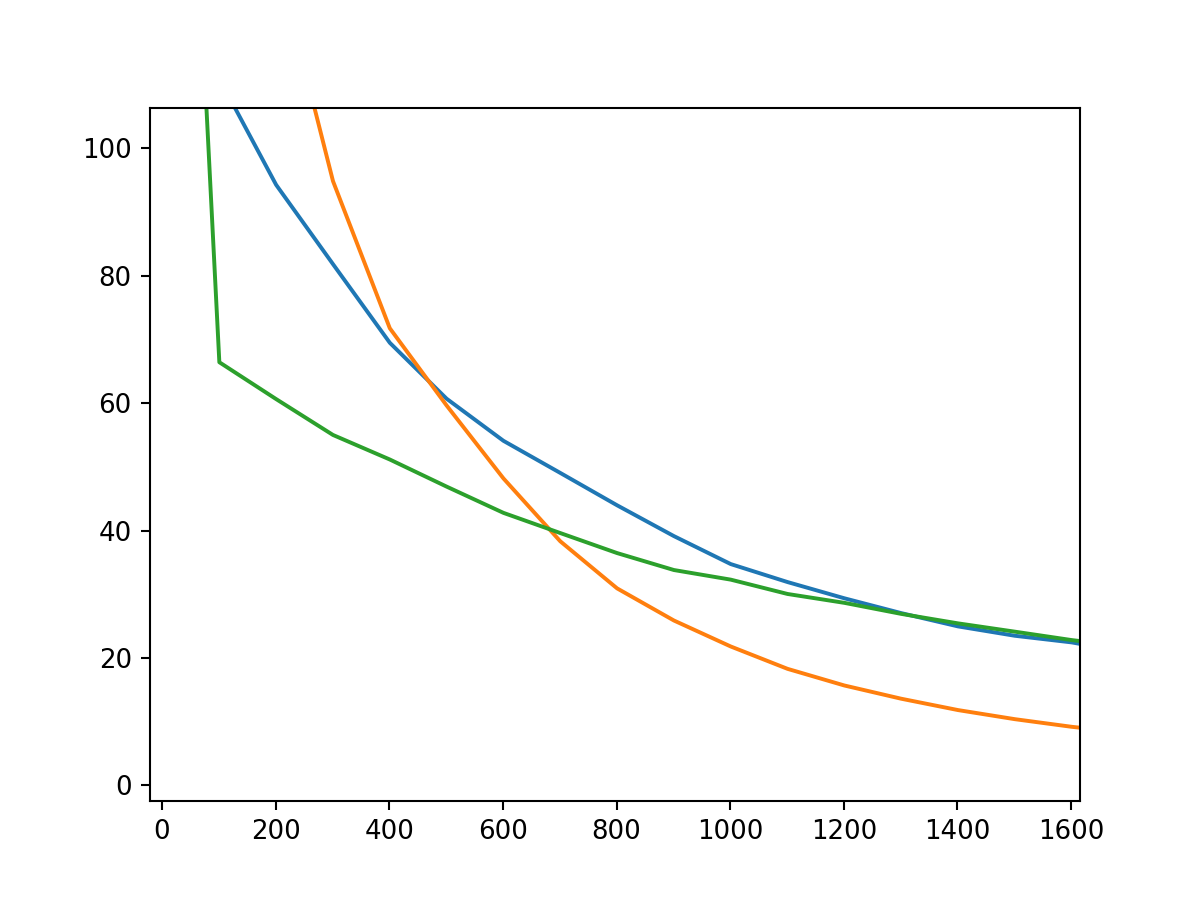

110.93145976084519

In [52]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.plot(num_agents_list,fps[62:124:2])
plt.plot(num_agents_list,one_cell_fps[:62:2])
plt.plot(num_agents_list,one_cell_fps[124::2])

fps[64]

In [3]:
simulation.segment_individuals()
len(simulation.cell_to_positions)

6889

In [3]:
EPSILON = .0000001
total_agents = 400
TIMESTEP = 0.2
number_of_states = 10  

#Simulation start time
t1 = time.clock()
#Random generator engine from a time-based seed
random.seed()

#Set parameters

arena_size = 1000
top_left = np.array([0.0,0.0])
bottom_right = np.array([arena_size,arena_size])


sight_num = 166  #make even


max_turning_rate = 114.5
body_size = 4.0
zoa = 12.0 * body_size
zor = 2.0 * body_size
zoo = 12.0 * body_size 
speed = 10
color = [255,135,71]

angular_error_sd = 0.0

ko = 0.25
ka = 0.25


agents = []


#Simulation starts HERE

#Set up agents
for indx_agents in range(total_agents):
    # needs to be a unit vector
    set_direction = np.array([1.0, 0.0])    
    set_direction = rotate(set_direction, random.random()*360.0)
    set_r_center = random_bounded_point(bottom_right, top_left)
    state = np.random.choice(np.arange(number_of_states))


    agents.append(Individual(set_r_center, set_direction, max_turning_rate,
                             speed, zoa, zoo, zor, angular_error_sd, 
                             body_size, state, ko, ka))

for indx_j in itertools.count():

    move_agents(arena_size, zoa, agents)


    #draw to screen
    if indx_j % 1 == 0:
        kill = graphics(arena_size, agents, zoa)

    if kill:
        close_cv2()
        break

NameError: name 'random_bounded_point' is not defined

In [1]:
test = [[] for _ in range(10)]
for indx in range(10):
    for indy in range(indx):
        test[indx].append([indx,indy])
        
    

In [2]:
print(test)

[[], [[1, 0]], [[2, 0], [2, 1]], [[3, 0], [3, 1], [3, 2]], [[4, 0], [4, 1], [4, 2], [4, 3]], [[5, 0], [5, 1], [5, 2], [5, 3], [5, 4]], [[6, 0], [6, 1], [6, 2], [6, 3], [6, 4], [6, 5]], [[7, 0], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6]], [[8, 0], [8, 1], [8, 2], [8, 3], [8, 4], [8, 5], [8, 6], [8, 7]], [[9, 0], [9, 1], [9, 2], [9, 3], [9, 4], [9, 5], [9, 6], [9, 7], [9, 8]]]


In [9]:
import torch
import numpy as np
np_array = np.concatenate((np.array(t) for t in test))
torch_np_array = torch.FloatTensor(np_array)
test_array = torch.cat((torch.FloatTensor(t) for t in test))
print(test_array)
print(torch_np_array)

TypeError: The first input argument needs to be a sequence

In [1]:
import torch
import numpy as np
import time

size = 10000
test = [[] for _ in range(size)]
for indx in range(size):
    for indy in range(400):
        test[indx].append([indx,indy])

first = False
runs = 5
time_sum = 0
for run in range(runs):
    t1 = time.time()
    for t in test:
        if t:
            x = torch.cuda.FloatTensor(t)
            #x = torch.FloatTensor(t)
            #np_array = x.numpy()
            #x = np.array(t)
            #print(x.shape)
    total = time.time() - t1
    print(total)
    time_sum += total
print('sum: ' , time_sum / runs)
    


16.9633686542511
15.817723274230957
15.796191453933716
15.847870588302612
15.786517143249512
sum:  16.042334222793578


10000:
torch: 1.2947082757949828

In [9]:
%timeit torch.FloatTensor(list(range(150))).cuda()

11.4 µs ± 46.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [36]:
import torch

original_list_1 = []
for i in range(10):
    original_list_1.append(np.array([i,i/2]))
print(type(original_list_1[0]))
original_list_2 = []
for i in range(10):
    original_list_2.append(np.array([i/5,i/3]))
print(original_list_2)
tensor = torch.cat([torch.FloatTensor(original_list_1), torch.FloatTensor(original_list_2)])
print(tensor)

second_list_1 = []
for i in range(10):
    second_list_1.append(tensor[i].numpy())
    
second_list_2 = []
for i in range(10):
    second_list_2.append(tensor[i+10].numpy().astype(dtype='float64'))
    
    
print(second_list_2)

<class 'numpy.ndarray'>
[array([ 0.,  0.]), array([ 0.2       ,  0.33333333]), array([ 0.4       ,  0.66666667]), array([ 0.6,  1. ]), array([ 0.8       ,  1.33333333]), array([ 1.        ,  1.66666667]), array([ 1.2,  2. ]), array([ 1.4       ,  2.33333333]), array([ 1.6       ,  2.66666667]), array([ 1.8,  3. ])]

 0.0000  0.0000
 1.0000  0.5000
 2.0000  1.0000
 3.0000  1.5000
 4.0000  2.0000
 5.0000  2.5000
 6.0000  3.0000
 7.0000  3.5000
 8.0000  4.0000
 9.0000  4.5000
 0.0000  0.0000
 0.2000  0.3333
 0.4000  0.6667
 0.6000  1.0000
 0.8000  1.3333
 1.0000  1.6667
 1.2000  2.0000
 1.4000  2.3333
 1.6000  2.6667
 1.8000  3.0000
[torch.FloatTensor of size 20x2]

[array([ 0.,  0.]), array([ 0.2       ,  0.33333334]), array([ 0.40000001,  0.66666669]), array([ 0.60000002,  1.        ]), array([ 0.80000001,  1.33333337]), array([ 1.        ,  1.66666663]), array([ 1.20000005,  2.        ]), array([ 1.39999998,  2.33333325]), array([ 1.60000002,  2.66666675]), array([ 1.79999995,  3.     

In [24]:
bottom = (10%4 == 1)
print(bottom)

False


In [62]:
from operator import itemgetter
print(itemgetter(2,5)(test_list))
print(test_list[1:3])

import torch
test = torch.FloatTensor([1,2,3,4,5])
test = test.cuda()

([1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6])
[[1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6]]


In [59]:


number_of_cells = 4

center_cell = 15

total_cells = number_of_cells * (number_of_cells) 

bottom = (center_cell % number_of_cells == number_of_cells - 1)
top = (center_cell % number_of_cells == 0)
left = (center_cell < number_of_cells)
right = (center_cell >= number_of_cells * (number_of_cells - 1))

print(top, bottom, left, right)

cells = []

for x in range(-1,2):
    for y in range(-1,2):
        x_adjusted = x
        y_adjusted = y
        
        if bottom and y == 1:
            x_adjusted -= 1
        if top and y == -1:
            x_adjusted += 1
            
        cell = center_cell + x_adjusted * number_of_cells + y_adjusted
        
        if right and x == 1:
            cell -= total_cells
        if left and x == -1:
            cell += total_cells
        cells.append(cell)
print(cells)

False True False True
[10, 11, 8, 14, 15, 12, 2, 3, 0]


In [ ]:
    # Part 2: Compute interactions
    for cell_x  in range(number_of_cells):
        for cell_y in range(number_of_cells):
           
            cell_id = cell_x * number_of_cells + cell_y
            if cell_to_agents_list[cell_id] != -1:

                for neighbor_x in range(cell_x - 1, cell_x + 2):
                    for neighbor_y in range(cell_y - 1, cell_y + 2):
                    
                        periodic_adjusted_x = neighbor_x;
                        periodic_adjusted_y = neighbor_y;
                        
                        if neighbor_x < 0:
                            periodic_adjusted_x += number_of_cells 
                        elif neighbor_x >= number_of_cells:
                            periodic_adjusted_x -= number_of_cells
                        
                        if neighbor_y < 0:
                            periodic_adjusted_y += number_of_cells
                        elif neighbor_y >=number_of_cells:
                            periodic_adjusted_y -= number_of_cells
                        
                        neighbor_cell_id = periodic_adjusted_x * number_of_cells + periodic_adjusted_y
                        
                        focal_agent_id = cell_to_agents_list[cell_id]
                        
                        while focal_agent_id != -1:
                            neighbor_agent_id = cell_to_agents_list[neighbor_cell_id]
                            
                            while neighbor_agent_id != -1:
                                if focal_agent_id != neighbor_agent_id:
                                    compute_social_forces(
                                        int(focal_agent_id), int(neighbor_agent_id), agents, arena_size)     
                                neighbor_agent_id = agents_to_agents_list[neighbor_agent_id]
                            focal_agent_id = agents_to_agents_list[focal_agent_id];

In [43]:
test = torch.cuda.FloatTensor()

In [44]:
test

[torch.cuda.FloatTensor with no dimension]

In [45]:
test.size()

torch.Size([])

In [46]:
if test.size():
    print('here')
else:
    print('Herer')

Herer


In [20]:
list(range(1,2100, 100))

[1,
 101,
 201,
 301,
 401,
 501,
 601,
 701,
 801,
 901,
 1001,
 1101,
 1201,
 1301,
 1401,
 1501,
 1601,
 1701,
 1801,
 1901]